In [1]:
import sys
sys.path = ['/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages'] + sys.path


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from matplotlib import pyplot as plt
import lal
import gwpy
from gwpy.timeseries import TimeSeries
import numpy as np
import pandas as pd
import seaborn as sns

/tmp/ipykernel_246/1120706772.py:2: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [3]:
MDC_PATH = "/cvmfs/et-gw.osgstorage.org/et-gw/PUBLIC/MDC1/data"
DATASETS = ['E0','E1','E2','E3','C1','C2']
CHANNELS = {n : f'{n}:STRAIN' for n in DATASETS}


In [4]:
e0 = TimeSeries.read(MDC_PATH+'/E1/E-E1_STRAIN_DATA-1000000000-2048.gwf', 'E1:STRAIN')
# The TimeSeries object contains various useful metadata
print(e0[1:10])

TimeSeries([-5.54284896e-23,  8.72894580e-23, -1.52215950e-22,
             1.93370972e-22, -1.56591158e-22,  2.12791581e-22,
            -7.75441870e-23, -5.23293157e-23, -7.15922186e-23]
           unit: strain,
           t0: 1000000000.0001221 s,
           dt: 0.0001220703125 s,
           name: E1:STRAIN,
           channel: None)


In [5]:
# Whitening the strain data using a window of 4 seconds and a step of 2 seconds
white = e0.whiten(4, 2)

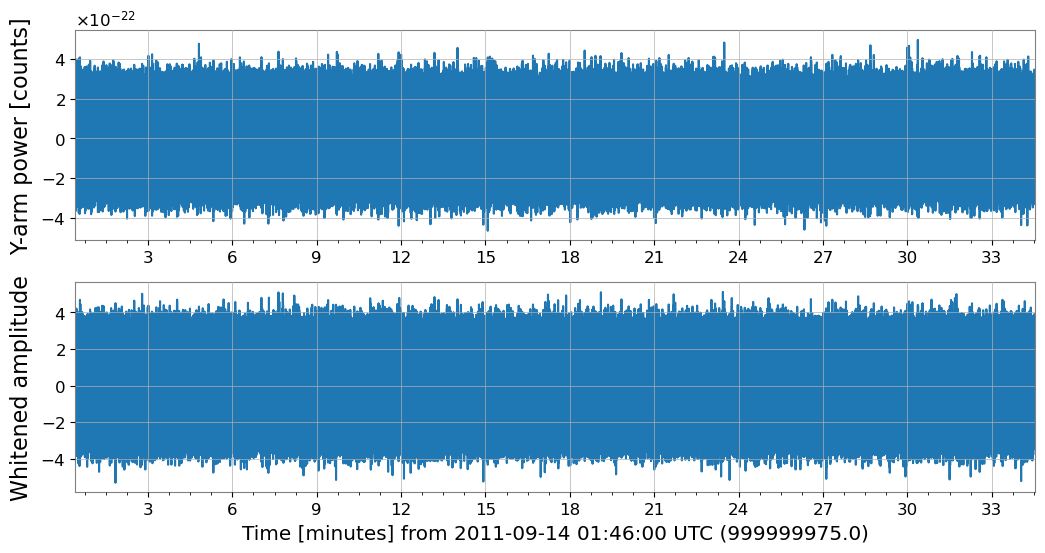

In [6]:
# Creating and displaying a multi-panel plot

# Import the 'Plot' class from the 'gwpy.plot' module
from gwpy.plot import Plot

# Create a multi-panel plot ('plot') with two panels: one for 'strain' data and one for 'white' data
# The 'separate=True' argument creates separate y-axes for each panel
# The 'sharex=True' argument shares the x-axis between the panels
plot = Plot(e0, white, separate=True, sharex=True)

# Set the y-axis label for the first panel (strain data)
plot.axes[0].set_ylabel('Y-arm power [counts]', fontsize=16)

# Set the y-axis label for the second panel (whitened data)
plot.axes[1].set_ylabel('Whitened amplitude', fontsize=16)

# Display the multi-panel plot
plot.show()

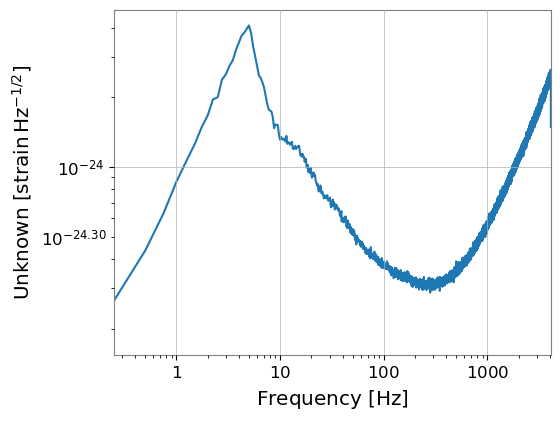

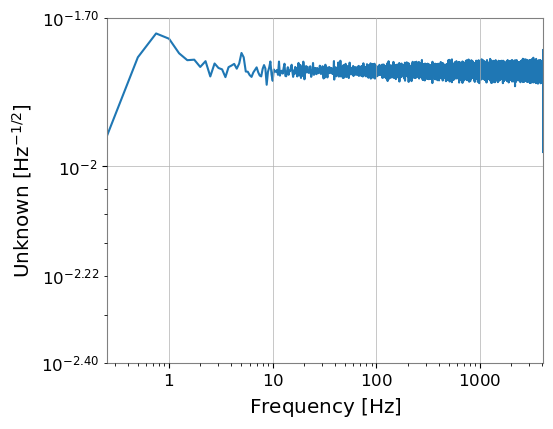

In [7]:
# Plotting Amplitude Spectral Density (ASD)

# Calculate and plot the ASD (Amplitude Spectral Density) of the original 'strain' data
# The 'fftlength=4' argument sets the length of the Fast Fourier Transform (FFT) window to 4 seconds
fig1 = e0.asd(fftlength=4).plot()

# Calculate and plot the ASD of the whitened 'white' data
# The 'fftlength=4' argument sets the length of the FFT window to 4 seconds
fig2 = white.asd(fftlength=4).plot()

# Uncomment the following lines to set custom x-axis and y-axis limits:
# plt.xlim(10, 2000)   # Set custom x-axis limits (frequency range)
# plt.ylim(1e-24, 1e-19)   # Set custom y-axis limits (ASD values)

In [8]:
signals = pd.read_csv('metadata/list_etmdc1_snr.txt', sep=' ')

There are 6767 signals with SNR>15.


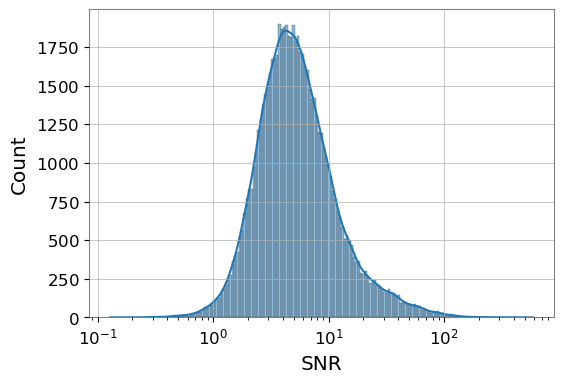

In [9]:
# Plot distribution of SNRs
print(f'There are {sum(signals["SNR"]>15)} signals with SNR>15.')
fig = plt.figure(figsize=(6,4))
ax = fig.gca()
sns.histplot(signals['SNR'], log_scale=(True,False), kde=True, ax=ax)
plt.show()


In [ ]:
 # Choose the top few signals to plot
Nplot = 10
top_sigs = signals.iloc[:Nplot]
from lal import MSUN_SI as Msun
from lalsimulation import SimIMRPhenomDChirpTime


def read_without_warnings(cachefile, channel, **kwargs):
    """Reads cache file while suppressing spurious LAL warnings.
    Wraps gwpy.timeseries.TimeSeries.read

    Args:
        cachefile (str): path to cache file
        channel (str): Channel name
        **kwargs: additional arguments passed to TimeSeries.read
    """
    prev_level = lal.GetDebugLevel()
    lal.ClobberDebugLevel(0)
    result = TimeSeries.read(cachefile, channel, **kwargs)
    lal.ClobberDebugLevel(prev_level)
    return result

def get_strain(tc, t_before = 4, t_after = 1):
    start_time = tc - t_before
    end_time = tc + t_after
    h = read_without_warnings('./caches/E1.lcf','E1:STRAIN',start=start_time, end=end_time)
    return h

def plot_specgram2(h):
    specgram = h.spectrogram2(fftlength=1/10,overlap=1/50)**(1/2)
    return specgram

for idx, pars in top_sigs.iterrows():
    tc =pars['tc']
    m1 = pars['m1']
    m2 = pars['m2']
    f_min = 10
    chirplen = SimIMRPhenomDChirpTime(pars['m1']*Msun, pars['m2']*Msun, pars['s1z'], pars['s2z'], f_min )
    print(f'Inj {int(pars["#"])}, tc {pars["tc"]}, Masses: {pars["m1"],pars["m2"]}, chirp length {chirplen} s, SNR {pars["SNR"]}')
    h = get_strain(tc, t_before=max(4,min(30,chirplen)))
    sg = h.spectrogram2(fftlength=1/10)**(1/2)
    plot = sg.plot(norm='log', yscale='log',
                   title=f'$t_c={tc}$, ($m_1$,$m_2$) = ({pars["m1"]:.1f},{pars["m2"]:.1f}) $M_\odot$, SNR={pars["SNR"]}',
                   ylim=(10,1000))
    ax = plot.gca()
    ax.colorbar(
        label=r'Gravitational-wave amplitude [strain/$\sqrt{\mathrm{Hz}}$]')
    h.plot()
plt.show()

Inj 42581, tc 1001620463.11925, Masses: (24.386689, 23.987984), chirp length 8.715954576399563 s, SNR 587.553918
Inj 42634, tc 1001622678.23317, Masses: (46.665966, 42.843973), chirp length 2.9100520001258174 s, SNR 386.213044
Inj 35118, tc 1001338345.05655, Masses: (2.4407, 1.356006), chirp length 666.8273392362823 s, SNR 383.954083
Inj 41037, tc 1001560353.66079, Masses: (67.810035, 67.58085), chirp length 1.3689245504858405 s, SNR 374.579215
Inj 56451, tc 1002152315.60553, Masses: (35.413761, 34.782889), chirp length 4.564479797758422 s, SNR 343.778187
Inj 6372, tc 1000245961.57657, Masses: (31.072686, 30.537128), chirp length 5.780289294117024 s, SNR 306.445678
Inj 6174, tc 1000238640.40425, Masses: (35.451717, 33.53639), chirp length 4.7513592679089705 s, SNR 294.129307
Inj 65098, tc 1002487317.70304, Masses: (49.596826, 47.039283), chirp length 2.6016271870256253 s, SNR 293.065507
Inj 28815, tc 1001095627.43992, Masses: (27.51567, 25.19244), chirp length 7.618475904330379 s, SNR 